### NYCT - from A to Z with XGBoost

#### importing the libraries used

In [1]:
import pandas as pd
import seaborn as sb
sb.set()
import numpy as np

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
test.tail()

id  vendor_id      pickup_datetime  passenger_count  \
625129  id3008929          1  2016-01-01 00:02:52                1   
625130  id3700764          1  2016-01-01 00:01:52                1   
625131  id2568735          1  2016-01-01 00:01:24                2   
625132  id1384355          1  2016-01-01 00:00:28                1   
625133  id0621643          2  2016-01-01 00:00:22                2   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
625129        -74.003464        40.725105         -74.001251   
625130        -74.006363        40.743782         -73.953407   
625131        -73.972267        40.759865         -73.876602   
625132        -73.976501        40.733562         -73.854263   
625133        -73.981850        40.716881         -73.969330   

        dropoff_latitude store_and_fwd_flag  
625129         40.733643                  N  
625130         40.782467                  N  
625131         40.748665                  N  
625132         40.891788                  N  
625133         40.769379                  N

### Visualization of the data to find relations

In [5]:
q = train["trip_duration"].quantile(0.99)    
train[train["trip_duration"] < q]
q_low = train["trip_duration"].quantile(0.01)
q_hi  = train["trip_duration"].quantile(0.99)

train = train[(train["trip_duration"] < q_hi) & (train["trip_duration"] > q_low)] #Removing outliers

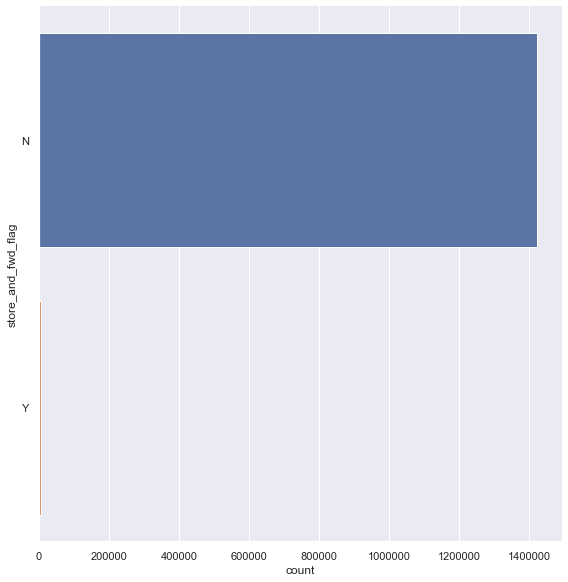

In [6]:
sb.catplot(y = 'store_and_fwd_flag', data = train, kind = "count", height = 8)

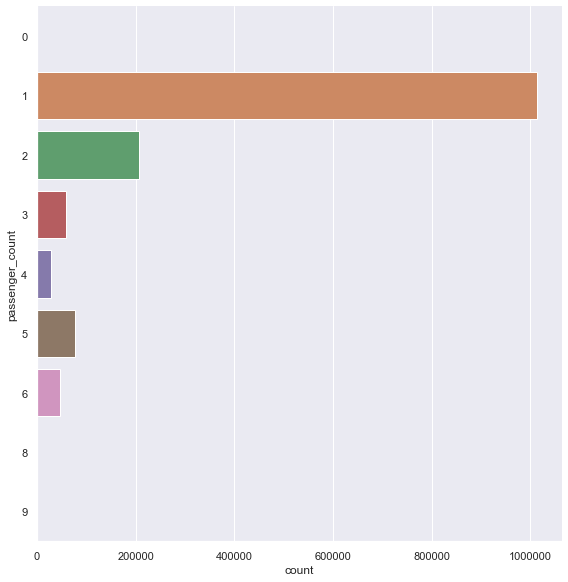

In [7]:
sb.catplot(y = 'passenger_count', data = train, kind = "count", height = 8)

In [8]:

train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [9]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429259 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1429259 non-null object
vendor_id             1429259 non-null int64
pickup_datetime       1429259 non-null object
dropoff_datetime      1429259 non-null object
passenger_count       1429259 non-null int64
pickup_longitude      1429259 non-null float64
pickup_latitude       1429259 non-null float64
dropoff_longitude     1429259 non-null float64
dropoff_latitude      1429259 non-null float64
store_and_fwd_flag    1429259 non-null object
trip_duration         1429259 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 130.9+ MB


In [11]:
train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.429259e+06     1.429259e+06      1.429259e+06     1.429259e+06   
mean   1.534893e+00     1.664980e+00     -7.397443e+01     4.075134e+01   
std    4.987812e-01     1.314633e+00      6.994360e-02     3.199226e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399192e+01     4.073764e+01   
50%    2.000000e+00     1.000000e+00     -7.398185e+01     4.075423e+01   
75%    2.000000e+00     2.000000e+00     -7.396776e+01     4.076838e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.429259e+06      1.429259e+06   1.429259e+06  
mean       -7.397390e+01      4.075208e+01   8.153230e+02  
std         6.997437e-02      3.515673e-02   5.731357e+02  
min        -1.219333e+02      3.218114e+01   8.800000e+01  
25%        -7.399134e+01      4.073618e+01   4.020000e+02  
50%        -7.397980e+01      4.075461e+01   6.620000e+02  
75%        -7.396326e+01      4.076987e+01   1.064000e+03  
max        -6.133553e+01      4.392103e+01   3.439000e+03

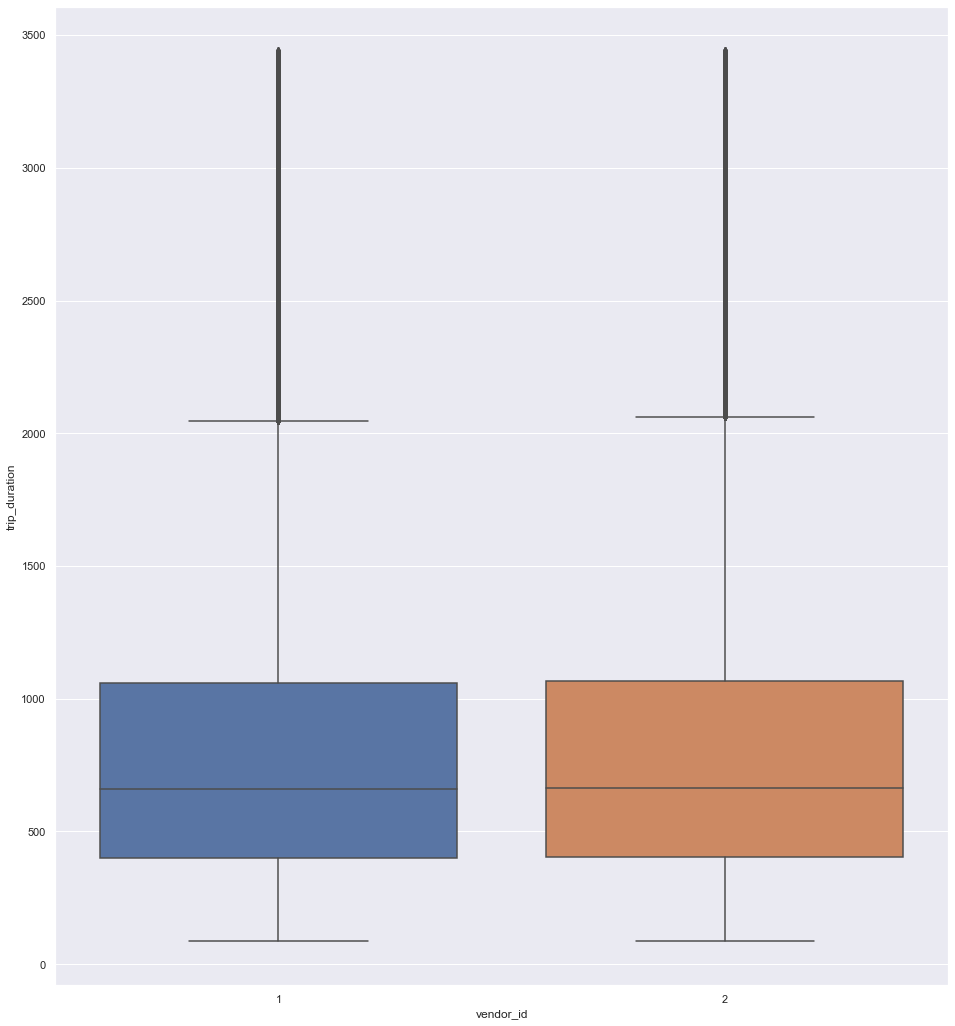

In [12]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 1, figsize=(16,18 ))
sb.boxplot(x = 'vendor_id', y = 'trip_duration', data = train) #Vendor Id is almost identicle

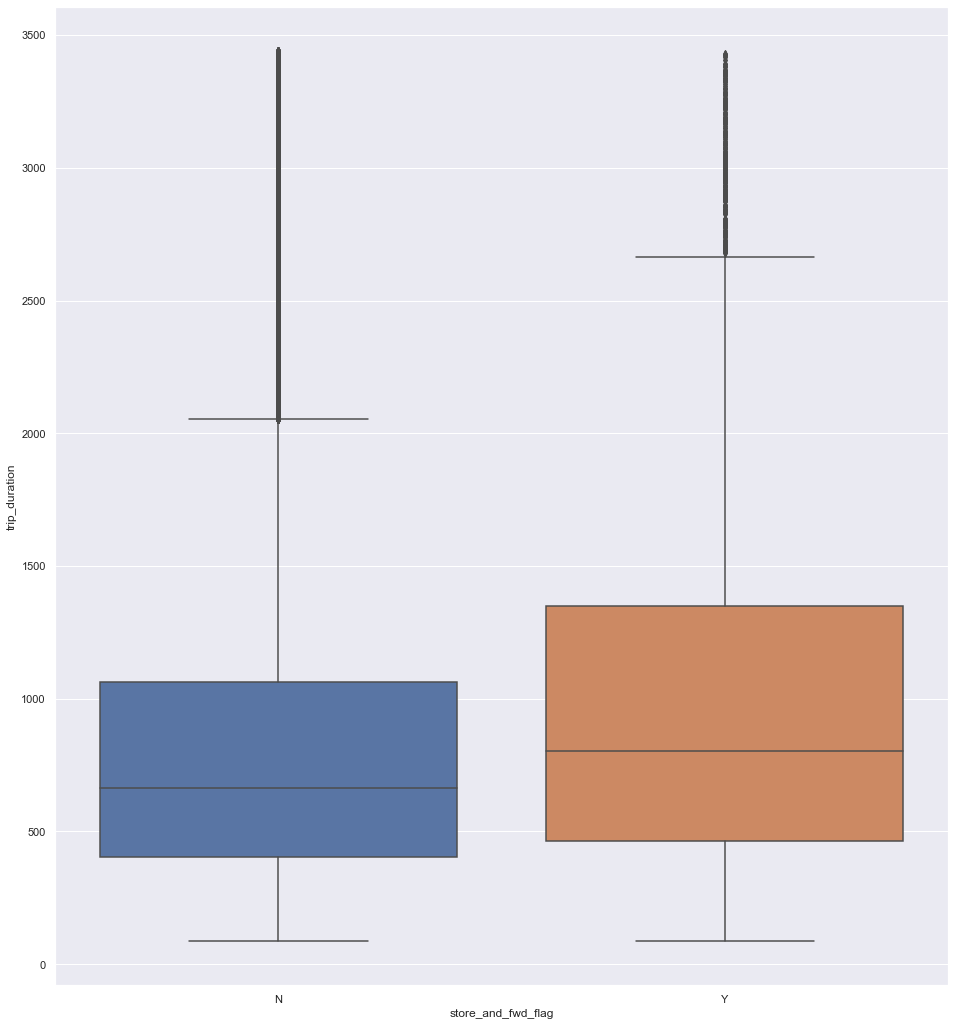

In [13]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 1, figsize=(16,18 ))
sb.boxplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = train)

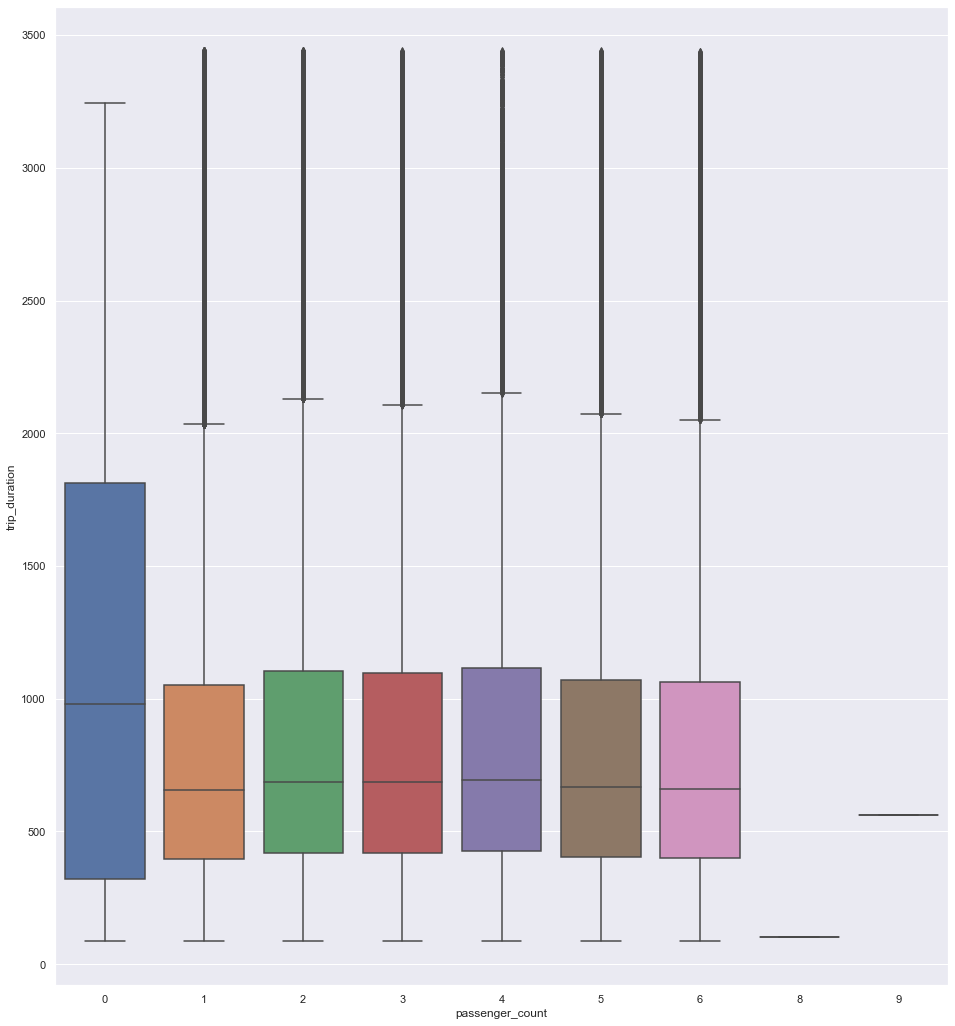

In [14]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 1, figsize=(16,18 ))
sb.boxplot(x = 'passenger_count', y = 'trip_duration', data = train)

In [15]:
exists = 0 in train.passenger_count
print(exists)

True


/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


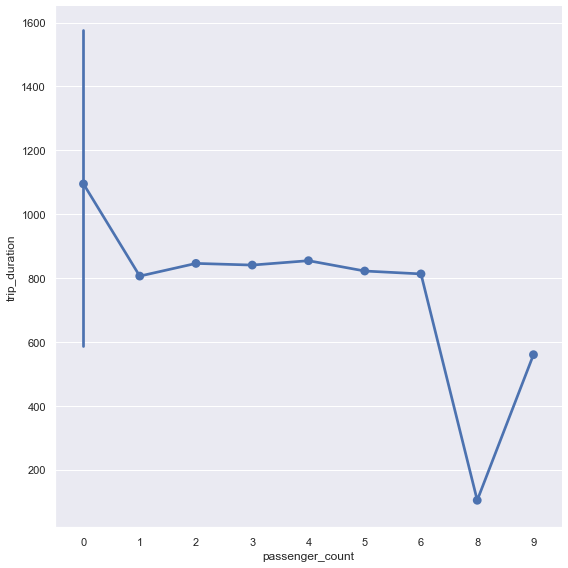

In [16]:
g  = sb.factorplot(x="passenger_count",y="trip_duration",data=train, size = 8)
g = g.set_ylabels("trip_duration")

#### Defining a function so that we can club 1 to 6 count of passengers as one as they are very similar in trip suration as observed from the graph above 

In [17]:
def pass_count(s):
    if (s >= 1) & (s <= 6):
        return 1
    elif s == 8:
        return 2
    elif (s >= 9):
        return 3
    elif (s == 0):
        return 0 
    
train['passenger_count']=train['passenger_count'].apply(pass_count)

test['passenger_count']=test['passenger_count'].apply(pass_count)


#### Using the pickup Latitude and Longitude to calculate the distance that the cab travelled using the havensine function

In [18]:
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) #2*R*asin...

In [19]:
lon2= pd.DataFrame(train['dropoff_longitude'])
lat2= pd.DataFrame(train['dropoff_latitude'])
lon1=pd.DataFrame(train['pickup_longitude'])
lat1 = pd.DataFrame(train['pickup_latitude'])

lon21= pd.DataFrame(test['dropoff_longitude'])
lat21= pd.DataFrame(test['dropoff_latitude'])
lon11=pd.DataFrame(test['pickup_longitude'])
lat11 = pd.DataFrame(test['pickup_latitude'])


#### Using Feature Engineering and Adding a new column called 'Distance_travelled' to the DataFrames

In [20]:
distance_traveled = [distance(lat1['pickup_latitude'].iloc[i], lon1["pickup_longitude"].iloc[i], lat2['dropoff_latitude'].iloc[i], lon2['dropoff_longitude'].iloc[i]) for i in range(0,len(lon2)) ]
distance_traveled_1 = [distance(lat11['pickup_latitude'].iloc[i], lon11["pickup_longitude"].iloc[i], lat21['dropoff_latitude'].iloc[i], lon21['dropoff_longitude'].iloc[i]) for i in range(0,len(lon21)) ]

In [21]:
train["total_distance"]= distance_traveled
test['total_distance']= distance_traveled_1

In [22]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  
0         40.765602                  N            455        1.498521  
1         40.731152                  N            663        1.805507  
2         40.710087                  N           2124        6.385098  
3         40.706718                  N            429        1.485498  
4         40.782520                  N            435        1.188588

#### Now we need to deal with the date_time column and we do this using the module datetime

In [23]:
from datetime import datetime

#### We add another column called day which indicates the different days that the cab was taken as this can affect the duration of the cab based on different traffic patterns

In [24]:
datetime_object_pickup = [datetime.strptime(train['pickup_datetime'].iloc[i], '%Y-%m-%d %H:%M:%S').weekday() for i in range(len(train['pickup_datetime']))]

In [25]:
datetime_object_pickup_test = [datetime.strptime(test['pickup_datetime'].iloc[i], '%Y-%m-%d %H:%M:%S').weekday() for i in range(len(test['pickup_datetime']))]

#### Sunday is defined as a 6 and monday as a 0

In [26]:
train['pickup_day']= datetime_object_pickup 
test['pickup_day']=datetime_object_pickup_test

In [27]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455        1.498521   
1         40.731152                  N            663        1.805507   
2         40.710087                  N           2124        6.385098   
3         40.706718                  N            429        1.485498   
4         40.782520                  N            435        1.188588   

   pickup_day  
0           0  
1           6  
2           1  
3           2  
4           5

#### Visualizing to see the trends in trip duration wrt to day of the week 

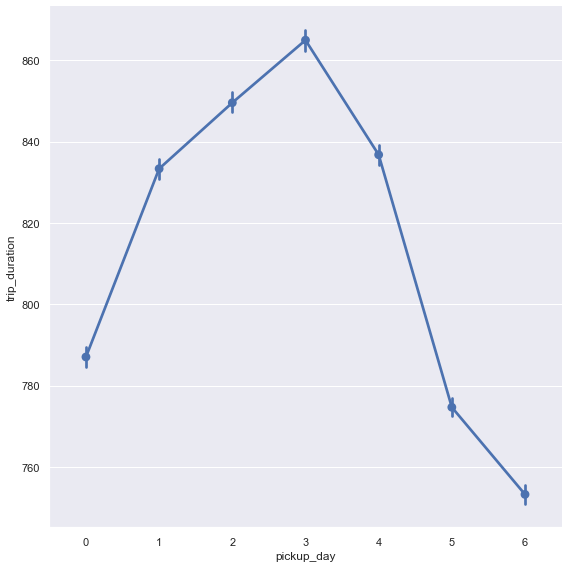

In [28]:
g  = sb.factorplot(x="pickup_day",y="trip_duration",data=train, size = 8)
g = g.set_ylabels("trip_duration")

In [29]:
train['pickup_datetime'] = [datetime.strptime(train['pickup_datetime'].iloc[i], '%Y-%m-%d %H:%M:%S') for i in range(len(train['pickup_datetime']))]
test['pickup_datetime'] = [datetime.strptime(test['pickup_datetime'].iloc[i], '%Y-%m-%d %H:%M:%S') for i in range(len(test['pickup_datetime']))]

#### Extracting the hour with the help of the datetime module as the time of the day also plays an important role in trends for the trip_duration. It is set in a 24 hour manner

In [30]:
train['Time'] = [(train['pickup_datetime'].iloc[i]).hour for i in range(len(train['pickup_datetime']))]
test['Time'] = [(test['pickup_datetime'].iloc[i]).hour for i in range(len(test['pickup_datetime']))]

#### Visualizing the result to see if any hours an be put in similar bins

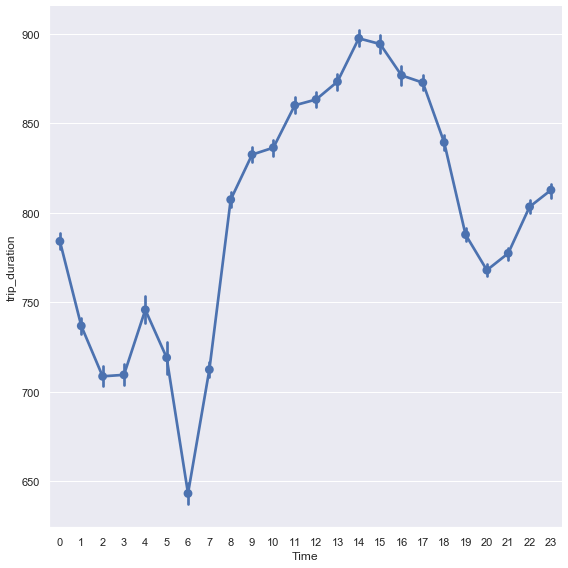

In [31]:
g  = sb.factorplot(x="Time",y="trip_duration",data=train, size = 8)
g = g.set_ylabels("trip_duration")

#### Calculation of the coorelation of the trip_duration with the pickup latitude and longitude to see whether they can be dropped

                   pickup_longitude  pickup_latitude  dropoff_longitude  \
pickup_longitude           1.000000         0.053479           0.804674   
pickup_latitude            0.053479         1.000000           0.117157   
dropoff_longitude          0.804674         0.117157           1.000000   
dropoff_latitude           0.103364         0.500500           0.137895   
trip_duration              0.162663        -0.166618           0.105061   

                   dropoff_latitude  trip_duration  
pickup_longitude           0.103364       0.162663  
pickup_latitude            0.500500      -0.166618  
dropoff_longitude          0.137895       0.105061  
dropoff_latitude           1.000000      -0.150346  
trip_duration             -0.150346       1.000000  


(5, 0)

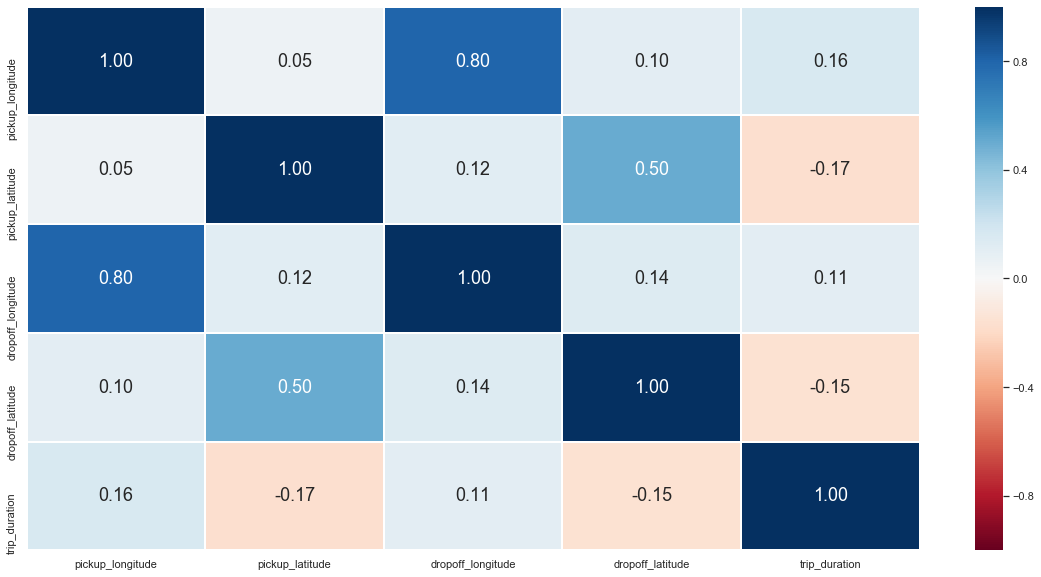

In [32]:
# Correlation Matrix
data = pd.DataFrame(train[['pickup_longitude', 'pickup_latitude' ,'dropoff_longitude' ,'dropoff_latitude', 'trip_duration']])
print(data.corr())

# Heatmap of the Correlation Matrix
f, axes = plt.subplots(1, 1, figsize=(20, 10))
# The font size can be passed with annot_kws
# The colors group can be passed with cmap
sb.heatmap(data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

#set limit to y axis for better visualization of map heat
#houseNumData.shape[1] fetch the column size of .shape command
axes.set_ylim(data.shape[1], 0)  #Very low correlation

#### Seeing as the correlation is less, it can be concluded that it can be dropped without completely comprimising the accuracy of the model

####  Now, We need to Label Encode the store_fwd_flag and we do so by using the Label_Encoder module

In [33]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [34]:

label = LabelEncoder()

for col in ['store_and_fwd_flag']:
    train[col] = label.fit_transform(train[col])

for col in ['store_and_fwd_flag']:
    test[col] = label.fit_transform(test[col])

#### Defining the X(Predictors) and Y (variable to Predcict) for the model 

In [48]:
x = train[[ 'passenger_count' ,'store_and_fwd_flag'  , 'total_distance' ,'pickup_day' ]]
x_test = test[[ 'passenger_count' ,'store_and_fwd_flag'  , 'total_distance' ,'pickup_day']]


In [49]:
y = train[['trip_duration']]


#### The regressor that I decieded to use to predict trip_duration is XGBoost

In [50]:
from xgboost import XGBRegressor

#### Fitting the model 

In [51]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(x, y)

[17:35:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### Predicting the trip_duration for the test DataFrame

In [52]:
answer = my_model.predict(x_test)

In [53]:
answer


array([ 899.9338 ,  899.9338 ,  522.11694, ..., 1584.7169 , 2442.7317 ,
       1371.869  ], dtype=float32)

In [54]:
submission = pd.DataFrame(columns=['id','trip_duration'])

In [55]:
submission

Empty DataFrame
Columns: [id, trip_duration]
Index: []

In [56]:
submission['id'] = test['id']

In [57]:
submission['trip_duration'] = answer

In [58]:
submission

id  trip_duration
0       id3004672     899.933777
1       id3505355     899.933777
2       id1217141     522.116943
3       id2150126    1316.846802
4       id1598245     413.410248
...           ...            ...
625129  id3008929     397.114624
625130  id3700764    1393.749390
625131  id2568735    1584.716919
625132  id1384355    2442.731689
625133  id0621643    1371.869019

[625134 rows x 2 columns]

In [59]:
submission.to_csv('submission5.csv',index=False)